In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.DataFrame()
for i in range(1):
    df_tmp = pd.read_csv('data.csv', header=0)
    df = pd.concat([df, df_tmp])

# View top 5 rows of dataframe
df.head()

,Trial,UserID,Orientation,Activity,Speed,TimeStamp,Chest_Accel_X,Chest_Accel_Y,Chest_Accel_Z
0,NaN,0,Folded Out,Sitting,NaN,1582128836418,2.256195,-1.522797,10.403519
1,NaN,0,Folded Out,Sitting,NaN,1582128836589,3.220734,-2.252838,10.422897
2,NaN,0,Folded Out,Sitting,NaN,1582128836780,-0.090683,-0.249100,12.276138
3,NaN,0,Folded Out,Sitting,NaN,1582128836966,-1.416305,-0.237137,9.461456
4,NaN,0,Folded Out,Sitting,NaN,1582128837155,-0.947800,0.250046,9.660065


In [3]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point, :]
test_data = df.iloc[split_point:, :]

print("Number of train spamples: ", len(train_data))
print("Number of test spamples: ", len(test_data))

Number of train spamples:  1309
Number of test spamples:  328


In [4]:

def concat(data):
    
    # Select chest data
    chest = data.iloc[:,6:9]
    chest.columns=['Chest_Accel_X','Chest_Accel_Y','Chest_Accel_Z']
    #Square root of sum of squares of accelerometer
    chest["MA"] = np.sqrt(np.square(chest['Chest_Accel_X']) + np.square(chest['Chest_Accel_Y']) + np.square(chest['Chest_Accel_Z']))
    

    #Extract Orientation
    orientation = data.iloc[:, 2] 
    orientation = orientation.to_frame()
    orientation.columns=['Orientation']
    #orientation = pd.concat([orientation]*2, ignore_index=True)
    
    # Extract labels 
    labels = data.iloc[:, 3] 
    labels = labels.to_frame()
    labels.columns=['Activity']
    labels = pd.concat([labels]*2, ignore_index=True)
    
    
    #Concatenate chest and orientation into single frame
    frames = [ chest,orientation]
    df = pd.concat(frames)
   
    return chest, labels  #change chest to orientation once working

# Generate input data and labels
train_X, train_y = concat(train_data)
test_X, test_y = concat(test_data)

In [5]:
train_X.head()

,Chest_Accel_X,Chest_Accel_Y,Chest_Accel_Z,MA
0,2.256195,-1.522797,10.403519,10.753722
1,3.220734,-2.252838,10.422897,11.139353
2,-0.090683,-0.249100,12.276138,12.279000
3,-1.416305,-0.237137,9.461456,9.569812
4,-0.947800,0.250046,9.660065,9.709671


In [6]:
train_y.head()

,Activity
0,Sitting
1,Sitting
2,Sitting
3,Sitting
4,Sitting


In [7]:
N_TIME_STEPS = 50 #sliding window length
STEP = 25 #Sliding window step size
N_FEATURES = 4 

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    last = df['UserID'].values[25]
    
    
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['Chest_Accel_X'].values[i: i + n_time_steps]
        ay = x['Chest_Accel_Y'].values[i: i + n_time_steps]
        az = x['Chest_Accel_Z'].values[i: i + n_time_steps]
        #orientation = x['Orientation'].values[i: i + n_time_steps]
        MA = x['MA'].values[i: i + n_time_steps]

    
       
        label = stats.mode(y['Activity'][i: i + n_time_steps])[0][0]
        segments.append([ ax, ay, az, MA])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_X, train_y, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_X, test_y, N_TIME_STEPS, STEP)

In [8]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

In [9]:

from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras import optimizers

N_CLASSES = 3
N_HIDDEN_UNITS = 32
L2 = 0.000001

model = Sequential([
    LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
         kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2), name="LSTM_1"),
    Flatten(name='Flatten'),
    Dense(N_HIDDEN_UNITS, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"),
    Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 50, 32)            4736      
_________________________________________________________________
Flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)                51232     
_________________________________________________________________
Dense_2 (Dense)              (None, 3)                 99        
Total params: 56,067
Trainable params: 56,067
Non-trainable params: 0
_________________________________________________________________


In [11]:

opt = optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:

BATCH_SIZE = 1024
N_EPOCHS = 30

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          validation_data=(X_test, y_test))


Train on 51 samples, validate on 12 samples
Epoch 1/30
51/51 [==============================] - 0s 10ms/step - loss: 1.1607 - accuracy: 0.2745 - val_loss: 1.0820 - val_accuracy: 0.1667
Epoch 2/30
51/51 [==============================] - 0s 775us/step - loss: 1.1105 - accuracy: 0.3137 - val_loss: 1.0320 - val_accuracy: 0.4167
Epoch 3/30
51/51 [==============================] - 0s 710us/step - loss: 1.0826 - accuracy: 0.3333 - val_loss: 0.9904 - val_accuracy: 0.5000
Epoch 4/30
51/51 [==============================] - 0s 652us/step - loss: 1.0644 - accuracy: 0.4902 - val_loss: 0.9682 - val_accuracy: 0.7500
Epoch 5/30
51/51 [==============================] - 0s 747us/step - loss: 1.0528 - accuracy: 0.5490 - val_loss: 0.9478 - val_accuracy: 0.9167
Epoch 6/30
51/51 [==============================] - 0s 689us/step - loss: 1.0446 - accuracy: 0.5686 - val_loss: 0.9316 - val_accuracy: 0.8333
Epoch 7/30
51/51 [==============================] - 0s 709us/step - loss: 1.0382 - accuracy: 0.5882 - va

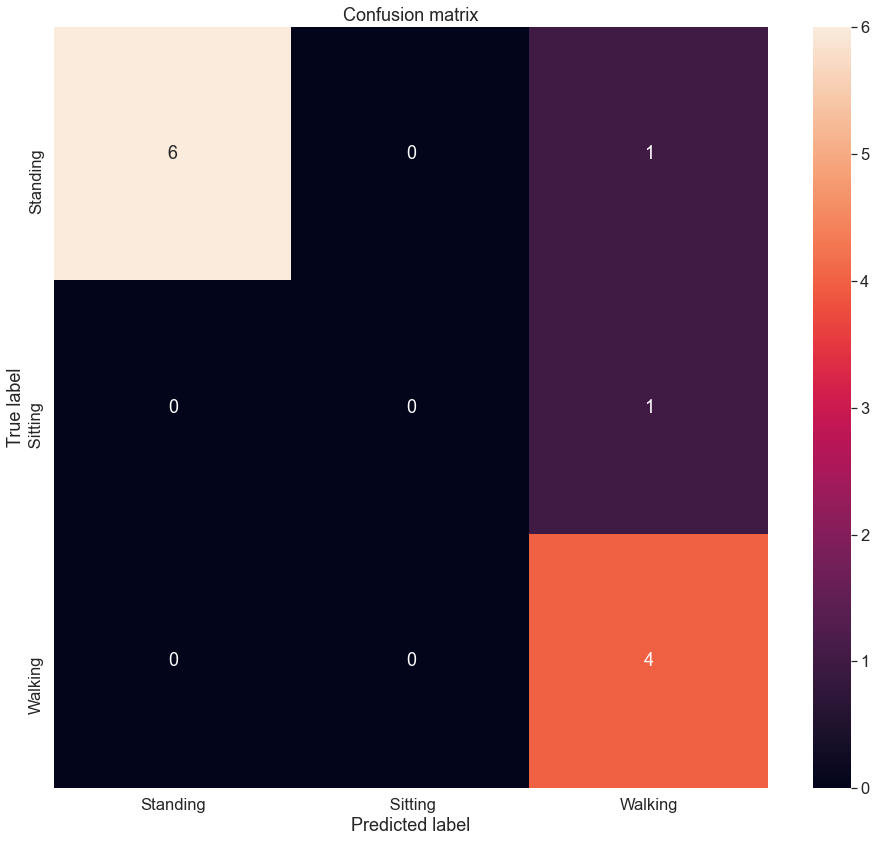

In [13]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

LABELS = ['Standing' ,' Sitting', 'Walking']

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [14]:

from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

input_node_names= ["LSTM_1_input"]
output_node_name = "Dense_2/Softmax"
MODEL_NAME = "HAR4"

tf.train.write_graph(K.get_session().graph_def, 'models', \
        MODEL_NAME + '_graph.pbtxt')
saver = tf.train.Saver()
saver.save(K.get_session(), 'models/' + MODEL_NAME + '.chkp')

freeze_graph.freeze_graph('models/' + MODEL_NAME + '_graph.pbtxt', None, \
    False, 'models/' + MODEL_NAME + '.chkp', output_node_name, \
    "save/restore_all", "save/Const:0", \
    'models/frozen_' + MODEL_NAME + '.pb', True, "")

Instructions for updating:
Use standard file APIs to check for files with this prefix.


IndexError: list index out of range